In [9]:
#구글드라이브와 colab 파일 연결

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import matplotlib.image as mpimg
import matplotlib.pylab as plt
import numpy as np

import matplotlib.pylab as pylab
from skimage import img_as_float
from skimage.io import imread
from skimage.morphology import skeletonize
import math #지문 분석, 비교를 위해 필요한 라이브러리들


def bin(img): #사진을 입력받아 이진화하는 함수.
  img_g = mpimg.imread(img)

  img_bin = np.zeros((144,144))


  bth = 127
  #임계치인 0~127까지는 1로, 128~255까지는 0으로 나타낸다. 
  img_bin[img_g<=bth] = 1
  img_bin[img_g>bth] = 0


#지문 이미지 바깥 값은 지문이 아닌데 들어가 있는 부분이므로, 0으로 처리해준다.
  for i in range(0,24):
    for j in range(0,144):
        img_bin[i][j] = 0

  for i in range(24,121):
    for j in range(0,144):
      if(j<24 or 119<j):
        img_bin[i][j]=0

  for i in range(120,144):
    for j in range(0,144):
        img_bin[i][j] = 0

  return img_bin



def skel(img): #사진을 입력받아 세선화(골격화)하는 함수.
  img_sk = skeletonize(img_bin)

  return img_sk



def identif(img): 
  #세선화 된 이미지를 받아 지문의 특징점을 찾아 배열에 저장해주는 함수.
  #3x3 window를 이용해 cn값 저장한다.

  img_np = np.zeros((144,144))
  cn = np.zeros((144,144)) #cn 값을 저장할 배열.
  p = np.zeros(10) # 3*3 window를 1차원 배열에 표현하기 위해 선언한 배열.
  m_list = [] #특징점의 x,y좌표, cn 값을 넣을 배열.
  #우리는 cn값의 비교는 하지 않아 cn 값을 저장해둘 필요는 없지만 저장하도록 만들었다. 



  #세선화 후 img_sk 배열 값이 true, false로 저장되어서 1, 0으로 바꾸는 과정을 거쳤다.
  for i in range(0,143):
    for j in range(0,143):
      if(img[i][j] == True):
        img_np[i][j] = int(1)  
      else:
        img_np[i][j] = int(0)


  for i in range (1,143):    #배열의 index는 0~143까지이고, 원래는 0~143까지 처리해야 하지만
    for j in range (1,143):  #지문 이미지의 가장 자리에는 지문 이미지가 없는 경우가 많으므로 (1,1)~(142,142)까지 옮긴다. 
      p[0] = img_np[i][j] 
      p[1] = img_np[i][j+1]
      p[2] = img_np[i-1][j+1]
      p[3] = img_np[i-1][j]
      p[4] = img_np[i-1][j-1]
      p[5] = img_np[i][j-1]
      p[6] = img_np[i+1][j-1]
      p[7] = img_np[i+1][j]
      p[8] = img_np[i+1][j+1]
      p[9] = p[1] # 3*3 윈도우를 p배열에 옮겨준다.

      
      #cn 값을 계산해준다.
      s = 0
      if(p[0] == 1):        #p[0]에 지문 정보가 있을 때만, 특징점 추출을 하면 된다.
        for k in range(1,9):
          s = s + abs(p[k] - p[k+1]) #for 문을 통해 cn 값 계산
          cn[i][j] = 0.5*s #계산 식을 이용.



  #특징점은 단점, 분기점을 따질 것이므로, 각각을 cn값을 이용해 찾아 
  #두 점 모두 특징점을 저장하는 배열인 m_list에 저장하여 리턴해준다.
  for i in range (0,143):
    for j in range (0,143):
      if(cn[i][j]==1): #단점일 때
        m_list.append([i,j,cn[i][j]])
      if(cn[i][j]==3): #분기점일 때
        m_list.append([i,j,cn[i][j]])

  return m_list



#두 지문의 특징점을 저장한 두 리스트를 비교해서 mr 값을 알려주는 함수 
#mth값에 따라 3개를 만들었다. 따라서, 설명은 mr10에만 적는다.
def mr10(list1, list2): #mth = 10
  mth = 10 
  mcnt = 0 #일치하는 특징점 개수를 담는다.

  #list1d에 담긴 특징점 전체와 list2에 담긴 특징점 전체의 거리를 계산하여 비교해야 한다.
  #따라서 for문을 이용해 거리를 비교하고
  #거리가 mth 이하인 두 특징점이 있으면 같은 특징점으로 간주하고 mcnt를 1 올린다.
  for i in range(0, len(list1)):
    for j in range(0, len(list2)):
      if(math.sqrt((list1[i][0] - list2[j][0])**2 + (list1[i][1] - list2[j][1])**2) <= mth):
        mcnt = mcnt + 1


  mr = 100*mcnt/(len(list1)*len(list2))  #계산이 끝나면 mcnt를 이용해 mr을 계산한다.
  
  return mr


def mr50(list1, list2): #mth = 50
  mth = 50 
  mcnt = 0


  for i in range(0, len(list1)):
    for j in range(0, len(list2)):
      if(math.sqrt((list1[i][0] - list2[j][0])**2 + (list1[i][1] - list2[j][1])**2) <= mth):
        mcnt = mcnt + 1

  mr = 100*mcnt/(len(list1)*len(list2)) 
  
  return mr



def mr100(list1, list2): #mth = 100
  mth = 100
  mcnt = 0

  for i in range(0, len(list1)):
    for j in range(0, len(list2)):
      if(math.sqrt((list1[i][0] - list2[j][0])**2 + (list1[i][1] - list2[j][1])**2) <= mth):
        mcnt = mcnt + 1

  mr = 100*mcnt/(len(list1)*len(list2)) 
  
  return mr 




#mr 값과 바로 이전 단계의 dcnt 값 count을 넣으면 다음 단계의 dcnt 값을 출력해줌
def dcnt10(mr, count): 
  dth = 10
   #두 비교 지문이 동일 지문인 경우 +1을 해준다.
  if(mr>=dth):
    count += 1

  return count

def dcnt30(mr, count): 
  dth = 30
  if(mr>=dth):
    count += 1

  return count

def dcnt50(mr, count): 
  dth = 50
  if(mr>=dth):
    count += 1

  return count

def dcnt70(mr, count): 
  dth = 70
  if(mr>=dth):
    count += 1

  return count

def dcnt90(mr, count): 
  dth = 90
  if(mr>=dth):
    count += 1

  return count


def frr(dcnt, compare): #
  frr = 100*(compare-dcnt)/compare
  return frr

def far(dcnt, compare):
  far = 100*dcnt/compare
  return far

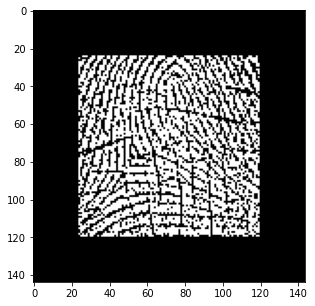

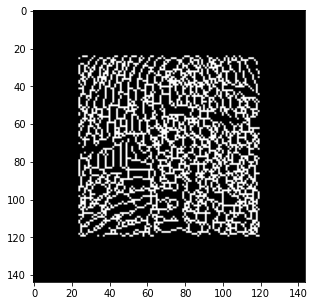

In [11]:
#이미지가 잘 처리되었는지 테스트하기 위한 코드

img_bin = bin('/gdrive/My Drive/ColabNote/BAS-HW01-Fingerprints/1 (1).bmp') #이진화
img_sk = skel(img_bin) #세선화


#이진화된 이미지 출력
plt.figure(figsize=(5,5))
plt.imshow(img_bin)
plt.axis('on'), plt.gray()
plt.show()

#세선화된 이미지 출력
plt.figure(figsize=(5,5))
plt.imshow(img_sk)
plt.axis('on'), plt.gray()
plt.show()

In [0]:
#특징점 추출
dcnt1 = 0

for h in range(1,9):
  for i in range(1,21): #이미지 h (i) 번의 특징점을 뽑아 listh_i (h, i는 이미지 이름에 있는 것과 같은 숫자)에 저장해둔다.
    globals()['list{}_{}'.format(h, i)] = []
    img_bin = bin('/gdrive/My Drive/ColabNote/BAS-HW01-Fingerprints/'+str(h)+' ('+str(i)+').bmp') #이진화
    img_sk = skel(img_bin) #세선화
    globals()['list{}_{}'.format(h,i)] = identif(img_sk) #특징점 추출 후 list에 대입

In [14]:
print(len(list1_1), len(list8_20), list1_1[0]) #특징점 값이 잘 저장 되었는지 테스트.

998 700 [24, 26, 1.0]


In [0]:
#mr 값을 배열에 저장
#과제 pdf 9쪽 표의 1열을 mr1_1[1~128]으로 2열을 mr1_2[1~128] ... 이런 형식으로 바꾼 것이다.
for i in range(1,9): #8사람의
  for j in range(1,5): #4개의 test set 지문과
    globals()['mr{}_{}'.format(i,j)]=np.zeros(128)
    
    a = 0 #1_1번 사람과 비교한 mr 값의 index가 0~127 이므로 변수 a를 따로 지정하여 사용한다.
    for k in range(1,9): #8사람의
      for l in range(5,21): #8개의 training set을 비교한 mr 값을 저정한다.
        globals()['mr{}_{}'.format(i, j)][a] = mr50(globals()['list{}_{}'.format(i,j)], globals()['list{}_{}'.format(k,l)]) #이 부분의 함수만 mr10, mr50, mr100으로 3번 변경해서 돌렸다.
        a+=1



In [52]:
print(len(mr1_1), mr1_1[0], len(mr8_4), mr8_4[127]) #mr 값이 잘 저장 되었는지 테스트

128 98.41815801178417 128 98.87111311401532


In [53]:
#identification
#mr 배열에서 각 행 별로 가장 큰 값의 배열 을 max1_1형태로, 
#그때의 열 번호 k값을 k1_1 이런 형태의 배열에 저장.
#열 번호는 0~127 이므로 나눴을때 몫에 +1을 하면 img x (y)에서 x와 같아진다.

index = 0 #index를 배열에 저장하기 위해 변수 선언

for i in range (1,9):
  for j in range(1,5):
    max = 0 
    globals()['max{}_{}'.format(i,j)] = np.zeros(1) #maxID값을 저장하기 위해 max1_1~max1_4, max2_1~max2_4, ... ,max8_1~max8_4 선언
    globals()['index{}_{}'.format(i,j)] = np.zeros(1) #maxID값의 인덱스를 저장하기 위해 위와 같이 index 배열 선언

    for k in range(0,128):
      if(max < globals()['mr{}_{}'.format(i, j)][k]): #mri_j 배열에서 최댓값을 찾는다. 그때 값을 max, index를 k에 넣는다.
        max = globals()['mr{}_{}'.format(i, j)][k]
        index = k #시시각각 max값과 index 값이 바뀌겠지만, 
        #k값을 이용해 도는 for문이 끝나면 max는 mri_j 배열의 최댓값을 index는 그 때의 index 값을 가지게 된다.

      #그 값을 maxi_j[0]과 indexi_j[0]에 저장.
    globals()['max{}_{}'.format(i,j)][0] = max     
    globals()['index{}_{}'.format(i,j)][0] = index




# 최대 매칭률을 가지는 지문에 대해 
# test지문 i_j 와 maxIDi_j[0]가 최댓값인 지문에 대해 
# 둘이 같은 ID를 가지면 1, 아니면 0을 oxi_j[0]에 저장하는 코드
for i in range(1,9):
  for j in range(1,5):
    globals()['ox{}_{}'.format(i,j)] = np.zeros(1)

    if( (i-1) == (globals()['index{}_{}'.format(i,j)][0]) // 16):
      globals()['ox{}_{}'.format(i,j)][0] = '1'
    else:
      globals()['ox{}_{}'.format(i,j)][0] = '0'
      

    

#nmr 계산을 위한 파트
m_cnt = 0 #nmr 값을 계산하기 위해 사용하는 변수  

for i in range(1,9):
  for j in range(1,5):
    if(globals()['ox{}_{}'.format(i,j)][0]==1):
      m_cnt += 1 #매칭된 지문(oxi_j에 1이 저장되어 있는 지문)의 개수를 센다

#m_cnt를 구하면 nmr 식에 넣어 계산해준다.
nmr = 100*(32-m_cnt)/32 
print(nmr)


84.375


In [54]:
#mr 값과 MaxID, ox 를 출력하는 코드.
#9페이지의 표를 채우기 위해 출력했다.

#보기 편하도록 맨 첫 행을 비교한 지문의 이름, maxID, matched로 뜨도록 했다.
print("      ", end="")

for i in range(1,9):
  for j in range(5,21):
    print("{:>6}".format('{}_{}'.format(i, j)), end=' ')
print("  maxID", end=' ')
print(" matched", end=' ')


#mr 값을 순서에 맞춰 전부 출력하는 코드.
for i in range(1,9):
  for j in range(1,5):
    print('\n')
    print("{}_{}".format(i,j), end = '   ') #열의 지문 ID를 출력
    a=0
    for k in range(1,9): 
      for l in range(5,21):
        print("{:6}".format(round(globals()['mr{}_{}'.format(i, j)][a],2)), end = ' ')
        a += 1
    iii = int(globals()['index{}_{}'.format(i, j)][0]//16)
    jjj = int(globals()['index{}_{}'.format(i, j)][0]%16)
    print("{:>7}".format('{}_{}'.format(iii,jjj)), end = ' ')
    print("{:>7}".format(int(globals()['ox{}_{}'.format(i, j)][0])), end = ' ')
 

         1_5    1_6    1_7    1_8    1_9   1_10   1_11   1_12   1_13   1_14   1_15   1_16   1_17   1_18   1_19   1_20    2_5    2_6    2_7    2_8    2_9   2_10   2_11   2_12   2_13   2_14   2_15   2_16   2_17   2_18   2_19   2_20    3_5    3_6    3_7    3_8    3_9   3_10   3_11   3_12   3_13   3_14   3_15   3_16   3_17   3_18   3_19   3_20    4_5    4_6    4_7    4_8    4_9   4_10   4_11   4_12   4_13   4_14   4_15   4_16   4_17   4_18   4_19   4_20    5_5    5_6    5_7    5_8    5_9   5_10   5_11   5_12   5_13   5_14   5_15   5_16   5_17   5_18   5_19   5_20    6_5    6_6    6_7    6_8    6_9   6_10   6_11   6_12   6_13   6_14   6_15   6_16   6_17   6_18   6_19   6_20    7_5    7_6    7_7    7_8    7_9   7_10   7_11   7_12   7_13   7_14   7_15   7_16   7_17   7_18   7_19   7_20    8_5    8_6    8_7    8_8    8_9   8_10   8_11   8_12   8_13   8_14   8_15   8_16   8_17   8_18   8_19   8_20   maxID  matched 

1_1    98.42  98.29  98.35  98.38  98.35  98.28  98.28  98.28  98.23  98.69  98

In [0]:
#으악

0


In [55]:
#verification
#1~8번 사람까지의 frr과 far을 구한다.


#1_1 부터 8_4 까지의 test set에서 1_1, 1_2 ... 8_4까지의 frr, far을 각각 계산.
for i in range (1,9):
  for j in range(1,5):
    count_frr = 0
    count_far = 0 #frr, far을 계산 하기 위해 사용하는 변수와
    globals()['frr{}_{}'.format(i, j)] = np.zeros(1)
    globals()['far{}_{}'.format(i, j)] = np.zeros(1) #test set의 frr, far을 frri_j[0], fari_j[0]에 저장하기 위해 배열을 만들었다. 


    for k in range(0,128): #1_5 ~ 8_20까지 training set에 대해 비교할 때

      if((k//16 + 1) == i): #k/16의 몫에 1을 더하면 ID값과 같아진다.
      #따라서 이 조건문을 만족하면 같은 사람의 (ID 앞자가 같은) 지문을 비교한 것이므로 
      #같은 사람의 지문인데 인식이 안된 frr 값을 구해야 한다.

        count_frr = dcnt50(globals()['mr{}_{}'.format(i, j)][k], count_frr)  # 이 부분을 5번 바꿔서 돌림.

        #mr 값이 dth보다 크면 count_frr을 하나 올림.
        #mr1_1[1]~mr1_1[16]에는 지문 1(1)과 1 (5) ~ 1 (20)까지 비교한 mr값이 들어있고 
        #mr1_1[17]~mr1_1[32]에는 지문 1(1)과 2 (5) ~ 2 (20)까지 비교한 mr값이 결과가 들어있고 
        #... 같은 형식으로 8 (20)까지 들어있다.
        
      else: #이 경우는 다른 사람의 지문인데 인식이 된 far값을 구한다.
        count_far = dcnt50(globals()['mr{}_{}'.format(i,j)][k], count_far) # 이 부분을 5번 바꿔서 돌림.
        #다른 사람의 지문에서 mr 값이 dth보다 크면 count_far을 하나 올림.


    globals()['frr{}_{}'.format(i, j)][0] = frr(count_frr, 16)
    globals()['far{}_{}'.format(i, j)][0] = far(count_far, 112)
    #i_j번째 지문의 dcnt를 세는 과정이 끝나면, 
    #count_frr, count_far 값으로 각 i_j 지문에 대해 frr, far을 계산한다.




#1,2, ..., 8 의 frr과 far의 평균 값 계산
#1번 사람의 frr(far) 값은 1_1, 1_2, 1_3, 1_4 frr(far) 값의 평균이다.
for i in range(1, 9):
  realfrr = 0
  realfar = 0
  globals()['realfrr{}'.format(i)] = np.zeros(1)
  globals()['realfar{}'.format(i)] = np.zeros(1) #frr, far의 평균값을 구해서 저장하기 위한 배열
  for j in range(1, 5):
    realfrr += globals()['frr{}_{}'.format(i, j)][0]
    realfar += globals()['far{}_{}'.format(i, j)][0] # 같은 사람의 (i_1 ~ i_4) frr, far 값을 다 더해준다
  
  globals()['realfrr{}'.format(i)][0] = realfrr/4
  globals()['realfar{}'.format(i)][0] = realfar/4 #다 더하면 4로 나누어 avg_frr, avg_far에 저장한다.


#전체적인 frr, far 값을 구하기 위한 코드.
whole_frr = 0
whole_far = 0

#real_frr, real_far 에 담긴 값을 평균 내준다.
for i in range(1,9):
  whole_frr += globals()['realfrr{}'.format(i)][0]/8

for i in range(1,9):
  whole_far += globals()['realfar{}'.format(i)][0]/8

#앞에서 얻은 frr, far값 출력
for i in range (1,9):
  print(i, globals()['realfrr{}'.format(i)][0], globals()['realfar{}'.format(i)][0])
print('w ' + str(whole_frr) + ' ' + str(whole_far))



1 0.0 100.0
2 0.0 100.0
3 0.0 100.0
4 0.0 100.0
5 0.0 100.0
6 0.0 100.0
7 0.0 100.0
8 0.0 100.0
w 0.0 100.0


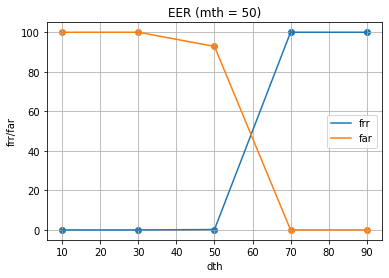

In [38]:
#EER 그래프 그리기 
#mth = 50인 경우의 그래프를 그리는 코드만 넣었다.

import pandas as pd
import matplotlib.pyplot as plt


dth = [10,30,50,70,90]


 #위의 식별, 검증 코드를 실행하여 얻은 데이터를 입력
frr = [0,0,0.19, 100,100]
far = [100,100,92.83,0,0]

#그래프 선 그리기
plt.plot(dth, frr, label = 'frr')
plt.plot(dth, far, label = 'far')


#그래프 점 그리기
plt.scatter(dth, frr)
plt.scatter(dth, far)


plt.grid()
plt.legend()
plt.xlabel('dth')
plt.ylabel('frr/far')

plt.title('EER (mth = 50)')

plt.show()